In [14]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

with nc.Dataset('zKuKaWSimL_KWAJp.nc') as f:
    zKuSimL_kwaj=f['zKuSim'][:,:]
    #zWSimL_kwaj=f['zWSim'][:,:]
    sfcPrecipL_kwaj=f['sfcPrecip'][:]
    piaKuL_kwaj=f['piaKu'][:]

with nc.Dataset('zKuKaWSimL_CONUSp.nc') as f:
    zKuSimL_conus=f['zKuSim'][:,:]
    #zWSimL_conus=f['zWSim'][:,:]
    sfcPrecipL_conus=f['sfcPrecip'][:]
    piaKuL_conus=f['piaKu'][:]

# concatenate the two datasets
zKuSimL=np.concatenate((zKuSimL_kwaj,zKuSimL_conus),axis=0)
sfcPrecipL=np.concatenate((sfcPrecipL_kwaj,sfcPrecipL_conus),axis=0)
piaKuL=np.concatenate((piaKuL_kwaj,piaKuL_conus),axis=0)

zKuSimL=np.array(zKuSimL)
zKuSimL[zKuSimL<12]=0
piaKuL=np.array(piaKuL)


In [15]:
zKuLn=np.array(zKuSimL)+np.random.normal(0,1.5,zKuSimL.shape)
piaKun=np.array(piaKuL)+np.random.normal(0,2.5,len(piaKuL))
xL=np.concatenate([(zKuLn[:,-11:]-20)/10,piaKun[:,np.newaxis]/2],axis=1)
yL=np.array(sfcPrecipL)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xL, yL, test_size=0.5, random_state=42)

from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=40,weights='distance')
import lightgbm as lgb
neigh.fit(x_train, y_train)
y_pred=neigh.predict(x_test)
y_predLGBM=neigh.predict(x_test)


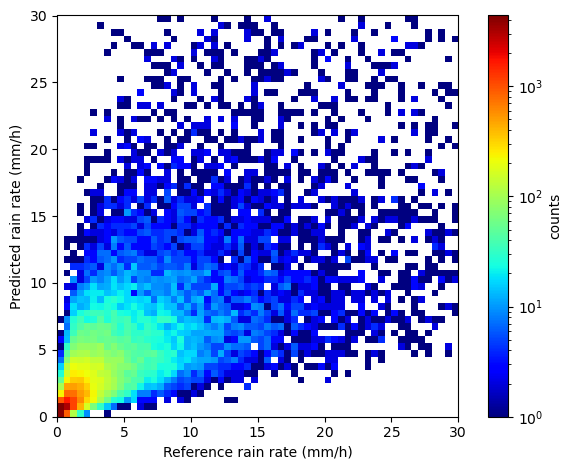

In [16]:
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
h2=plt.hist2d(y_test,y_pred,bins=np.arange(61)*0.5,norm=LogNorm(),cmap='jet')
ax.set_aspect('equal')
plt.xlabel('Reference rain rate (mm/h)')
plt.ylabel('Predicted rain rate (mm/h)')
c=plt.colorbar(label='counts')
plt.tight_layout()
plt.savefig('knnRegrPrecipKu_CONUS_KWAJ.png')

#s/r=a*(R0/R)^b*(L0/L)^c*(T0/T)^d
#C=0.70


[0.7156640818141263, 0.3425859966119996, 0.08154084118010921, -0.07165810695432019]
[1.539690904175862, 0.9637325362639957, 0.7081054150275315, 0.606353860179902]


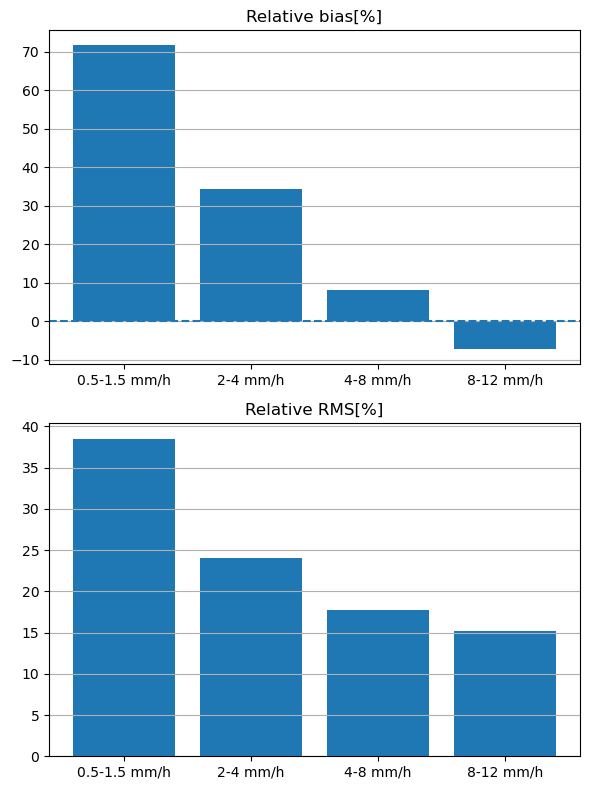

In [18]:
evalInt=[[0.5,1.5],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
for int1 in evalInt:
    a=np.nonzero((y_test>=int1[0]) & (y_test<int1[1]))
    bias=np.mean(y_predLGBM[a]-y_test[a])/np.mean(y_test[a])
    rms=np.sqrt(np.mean((y_predLGBM[a]-y_test[a])**2))/np.mean(y_test[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0.5-1.5 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100*0.25)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('knnRegrPrecipScoresKuCONUS_KWAJ.png')

print(biasL)
print(rmsL)